# Milestone 5: Visualizing Results

In this milestone, we created visualizations using PySpark, NumPy, Matplotlib, and Seaborn to determine which features are most relevant to flight price.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import os

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("ML Pipeline") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", 1000)


# function to save plot to GCS
def save_fig(plt, img_name, img_type="png"):
    print(f"Saving {img_name}...")
    img_data = io.BytesIO()
    plt.savefig(img_data, format=img_type, bbox_inches='tight')
    img_data.seek(0)
    storage_client = storage.Client()
    bucket = storage_client.bucket("my-bigdatatech-project-jl")
    blob = bucket.blob(f"visualizations/{img_name}.{img_type}")
    blob.upload_from_file(img_data, content_type=f"image/{img_type}")
    print(f"{img_name} successfully saved to GCS!")

# data used for model
gcs_path = 'gs://my-bigdatatech-project-jl/trusted/processed_data/*'

# load data into pyspark df
df_spark = spark.read.parquet(gcs_path)

df_spark.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/14 00:46:55 INFO SparkEnv: Registering MapOutputTracker
24/12/14 00:46:55 INFO SparkEnv: Registering BlockManagerMaster
24/12/14 00:46:55 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/12/14 00:46:55 INFO SparkEnv: Registering OutputCommitCoordinator


root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: float (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: integer (nullable = true)
 |-- isRefundable: integer (nullable = true)
 |-- isNonStop: integer (nullable = true)
 |-- baseFare: float (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: string (nullable = true)
 |-- segmentsAirlineName: string (nullable = true)
 |-- segmentsAirlineCode: string (nullable = true)
 |--

In [4]:
from pyspark.ml.tuning import CrossValidatorModel


model_path = "gs://my-bigdatatech-project-jl/models/linear_regression_model"

cv_model = CrossValidatorModel.load(model_path)

# load pipelinemodel into variable
best_pipeline = cv_model.bestModel

# extract model
lr_model = best_pipeline.stages[-1]

print("Linear Regression model extracted successfully.")



Linear Regression model extracted successfully.


In [5]:
from pyspark.sql.functions import col


# Outlier detection for 'totalFare' using IQR
quantiles = df_spark.approxQuantile("totalFare", [0.25, 0.75], 0.01)
Q1, Q3 = quantiles
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_spark = df_spark.filter((col("totalFare") >= lower_bound) & (col("totalFare") <= upper_bound))

df_spark.select("totalFare").describe().show()

+-------+------------------+
|summary|         totalFare|
+-------+------------------+
|  count|            308143|
|   mean|358.57142229436033|
| stddev|173.93342484571724|
|    min|             23.97|
|    max|             874.3|
+-------+------------------+



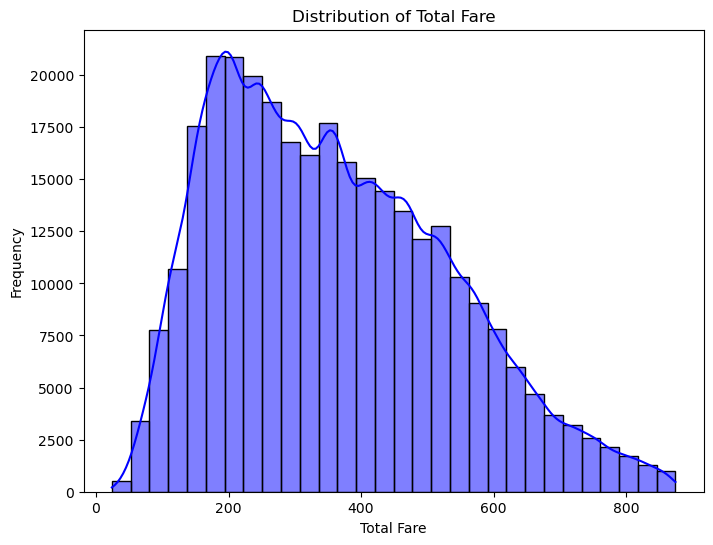

In [6]:


# Distribution of total fare in flight data
import matplotlib.pyplot as plt
import seaborn as sns

# totalFare
plt.figure(figsize=(8, 6))
sns.histplot(df_spark.toPandas()['totalFare'], kde=True, color='blue', bins=30)
plt.title("Distribution of Total Fare")
plt.xlabel("Total Fare")
plt.ylabel("Frequency")
plt.show()

# normal distribution with highest frequency total fare being <=500 

In [7]:

from pyspark.sql.functions import isnan

sampled_df = df_spark.sample(fraction=0.01, seed=42)

# split data into training and testing sets
train_data, test_data = sampled_df.randomSplit([0.7, 0.3], seed=42)

# remove nan values
train_data = train_data.filter(~isnan("totalFare"))
test_data = test_data.filter(~isnan("totalFare"))


In [8]:
# Load the saved predictions from the Parquet file
predictions = spark.read.parquet("gs://my-bigdatatech-project-jl/predictions/predictions_data")

# Show the predictions
predictions.show()


+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+------------------------+----------------------+--------------------------+----------------------------+--------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+--------------------+--------------------+--------------------+--------------------+------------------------+------------------------+------------------+------------------+---------+-----------+------+------------+---------------+------------------+------------------------+-----------+---------------------+-------------+----------------------+--------------------+------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|

<Figure size 640x480 with 0 Axes>

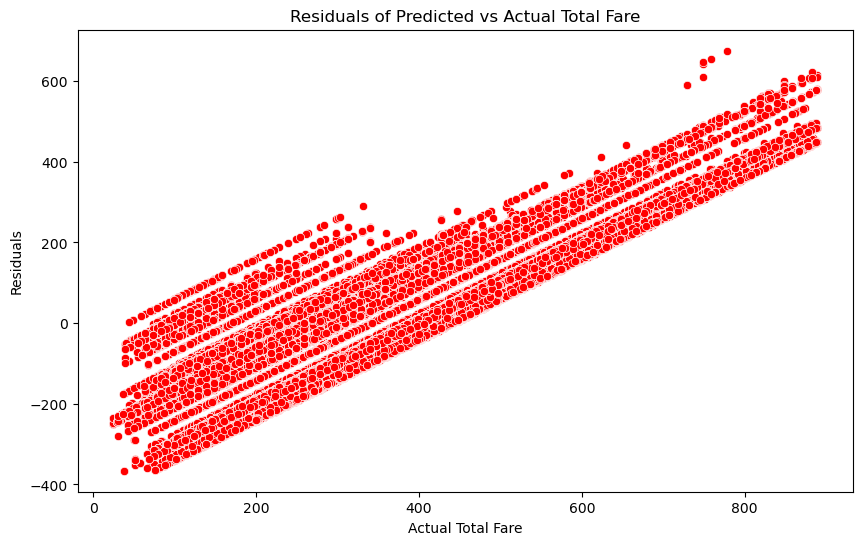

In [9]:
predictions_data = predictions.select("totalFare", "prediction").toPandas()
predictions_data['residuals'] = predictions_data['totalFare'] - predictions_data['prediction']

plt.clf()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_data['totalFare'], y=predictions_data['residuals'], color='red')
plt.title("Residuals of Predicted vs Actual Total Fare")
plt.xlabel("Actual Total Fare")
plt.ylabel("Residuals")

plt.show()



Saving correlation_matrix...


NameError: name 'io' is not defined

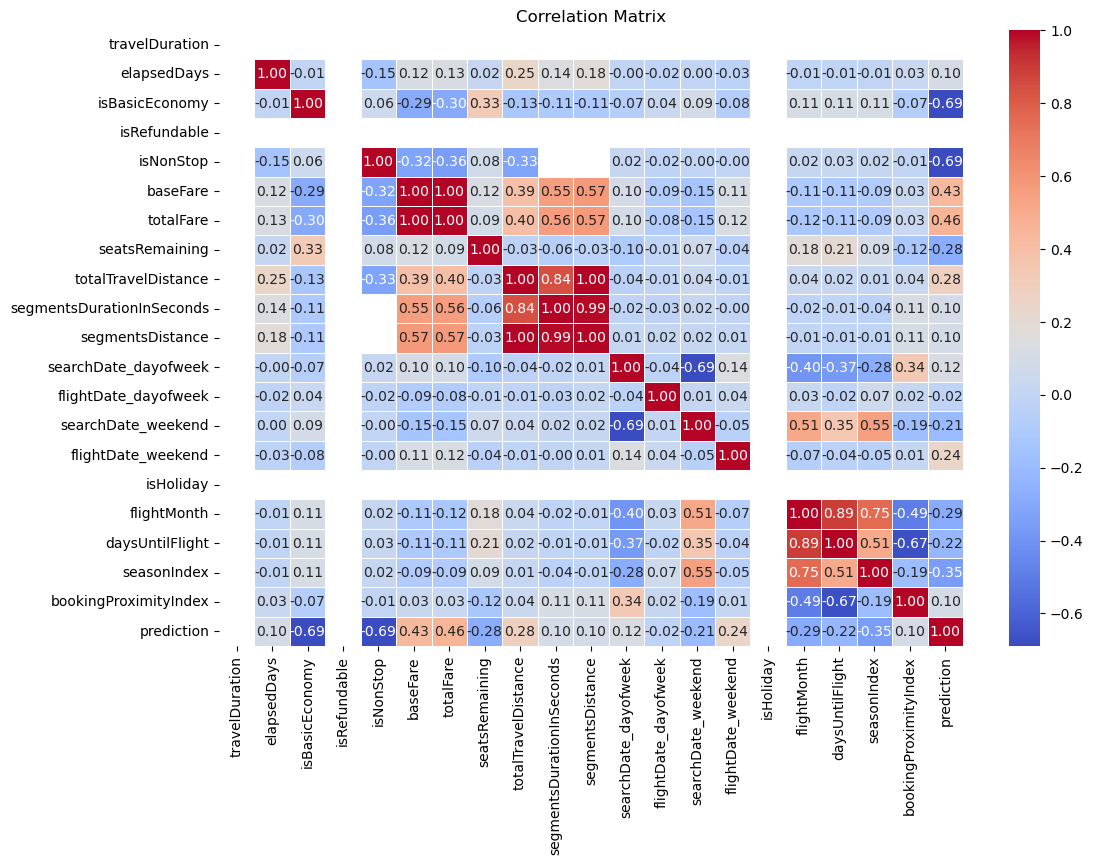

In [10]:
import numpy as np

# Sampling 1000 rows from the dataframe
small_df_spark = df_spark.limit(1000)

# use only numeric columns
small_df_pd = small_df_spark.toPandas()
numeric_cols = small_df_pd.select_dtypes(include=[np.number]).columns
corr_df_numeric = small_df_pd[numeric_cols].corr()

# create corr matrix
corr_matrix = corr_df_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df_numeric, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
save_fig(plt, "correlation_matrix")
plt.close()


Saving feature_importance...


NameError: name 'io' is not defined

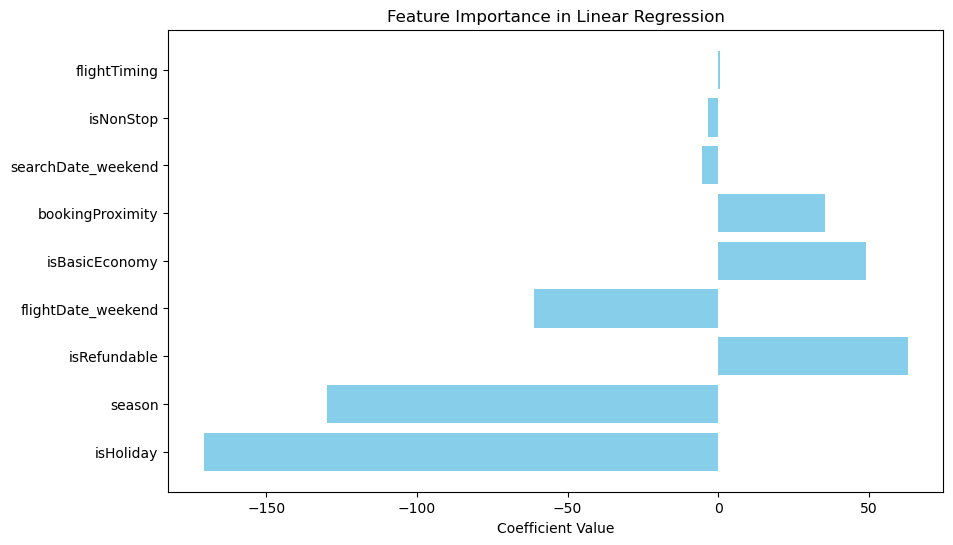

In [11]:
import matplotlib.pyplot as plt

coefficients = lr_model.coefficients.toArray()


feature_names = ['isRefundable', 'isBasicEconomy', 'isNonStop', 'searchDate_weekend', 
                 'flightDate_weekend', 'isHoliday', 'season', 'flightTiming', 'bookingProximity']

feature_importance = list(zip(feature_names, coefficients))

feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

sorted_feature_names, sorted_coefficients = zip(*feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
save_fig(plt, "feature_importance")
plt.close()

print("Visuals saved successfully")

In [12]:
# get hyperparameters from LR model
print("Best Model Parameters:")
for param, value in lr_model.extractParamMap().items():
    print(f"{param.name}: {value}")

Best Model Parameters:
aggregationDepth: 2
elasticNetParam: 1.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: totalFare
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 50
predictionCol: prediction
regParam: 0.001
solver: auto
standardization: True
tol: 1e-06


In [13]:


# Stop Spark session
spark.stop()